In [2]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../../..'))) # access sibling directories
sys.path.append(os.path.abspath(os.path.join('../../../../BayesFlow_dev/BayesFlow/')))

from src.python.settings import DEFAULT_KEYS
from src.python.networks import HierarchicalInvariantNetwork, ModelProbabilityNetwork
from src.python.models import HierarchicalSdtMptSimulator, MainSimulator
from src.python.losses import softmax_loss
from src.python.visualization import perf_tester

import numpy as np
import bayesflow as bf
import tensorflow as tf
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

In [3]:
# Hack to correctly set facecolor to white
# matplotlib 3.5 only sets facecolor if a plot was already created 
_ = plt.figure()
plt.rcParams['figure.facecolor'] = 'w'

<Figure size 640x480 with 0 Axes>

# Load network

In [4]:
sum_config = {"units": 128, "activation": "elu", "kernel_initializer": "glorot_normal"}
summary_net = bf.summary_networks.HierarchicalNetwork([
    bf.networks.DeepSet(dense_s2_args=sum_config, dense_s3_args=sum_config), 
    bf.networks.DeepSet(dense_s2_args=sum_config, dense_s3_args=sum_config)
    ])
probability_net = bf.inference_networks.PMPNetwork(num_models=2, dropout=False)
amortizer = bf.amortizers.AmortizedModelComparison(probability_net, summary_net)

In [5]:
# Training steps
epochs = 50 
iterations_per_epoch = 1000

# Checkpoint path for loading pretrained network and saving the final network
# TEMPORARY: SPECIFIC FOLDER
checkpoint_path = 'C:/Users/lasse/OneDrive/Ph.D/Projekte/hierarchical_model_comparison/checkpoints/02_bridge_sampling_comparison/non_nested_models/40_epochs_lr1e4_128eluglorotnormal_0.177avg.loss'

trainer = bf.trainers.Trainer(
    amortizer=amortizer, 
    default_lr=0.0001,
    checkpoint_path=checkpoint_path
    )

# Sample size
n_clusters = 25
n_obs = 50

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Loaded loss history from C:/Users/lasse/OneDrive/Ph.D/Projekte/hierarchical_model_comparison/checkpoints/02_bridge_sampling_comparison/non_nested_models/40_epochs_lr1e4_128eluglorotnormal_0.177avg.loss\history_40.pkl.
INFO:root:Networks loaded from C:/Users/lasse/OneDrive/Ph.D/Projekte/hierarchical_model_comparison/checkpoints/02_bridge_sampling_comparison/non_nested_models/40_epochs_lr1e4_128eluglorotnormal_0.177avg.loss\ckpt-40


# Get OOD score

## Utility functions

In [86]:
def noise_simulator(batch_size, n_clusters=25, n_obs=50, RNG=None, **kwargs):
    """ Generates a single hierarchical data set. """
    if RNG is None:
        RNG = np.random.default_rng()
    data = RNG.integers(low=0, high=2, size=(batch_size, n_clusters, n_obs, 2)) 
    #data = RNG.integers(low=-100, high=101, size=(batch_size, n_clusters, n_obs, 2))

    out_dict = {
        DEFAULT_KEYS["sim_data"]: data,
    }

    return out_dict

In [7]:
# Generative models
sdtmpt_model = HierarchicalSdtMptSimulator()

sdt_simulator = partial(sdtmpt_model.generate_batch, model_index=0, n_clusters=n_clusters, n_obs=n_obs, n_vars=2)
mpt_simulator = partial(sdtmpt_model.generate_batch, model_index=1, n_clusters=n_clusters, n_obs=n_obs, n_vars=2)

In [8]:
def get_max_activation(data, probability_net, summary_net, method):
    """ Gets the inference networks' last-layer-activation, either before or after 
    passing it through the softmax function. """

    if method=='max_softmax':
        activations = np.concatenate([probability_net.posterior_probs(summary_net(chunk)) for chunk in tf.split(data, 20)])
    if method=='max_logits':
        activations = np.concatenate([probability_net.logits(summary_net(chunk)) for chunk in tf.split(data, 20)])
          
    max_activation = np.max(activations, axis=1)

    return max_activation

## Data generation

In [9]:
num_data_sets = 5000

sdt_data = sdt_simulator(num_data_sets)['sim_data']
mpt_data = mpt_simulator(num_data_sets)['sim_data']
noise_data = noise_simulator(num_data_sets)['sim_data']

## max_softmax

In [10]:
sdt_max_softmax = get_max_activation(sdt_data, probability_net, summary_net, 'max_softmax')
mpt_max_softmax = get_max_activation(mpt_data, probability_net, summary_net, 'max_softmax')
noise_max_softmax = get_max_activation(noise_data, probability_net, summary_net, 'max_softmax')
print(np.mean(sdt_max_softmax), np.mean(mpt_max_softmax), np.mean(noise_max_softmax))

0.9403047 0.9326513 0.9942662


In [11]:
def get_percentage_rejected(model_activations, noise_activations, ci=[0.025, 0.975]):

    proportions_rejected = []

    for activations in model_activations:
        lower_threshold, upper_threshold = np.quantile(activations, q=ci, axis=0)
        print(lower_threshold, upper_threshold)
        print(np.max(noise_activations))
        rejected = np.logical_or(noise_activations < lower_threshold, noise_activations > upper_threshold)
        proportion_rejected = np.sum(rejected) / len(noise_activations)
        proportions_rejected.append(proportion_rejected)

    return proportions_rejected

get_percentage_rejected([sdt_max_softmax, mpt_max_softmax], noise_max_softmax)

0.5727825313806534 0.9968574047088623
0.9959132
0.5800033718347549 0.9970153376460076
0.9959132


[0.0, 0.0]

Text(0.5, 1.0, 'MaxSoftmax')

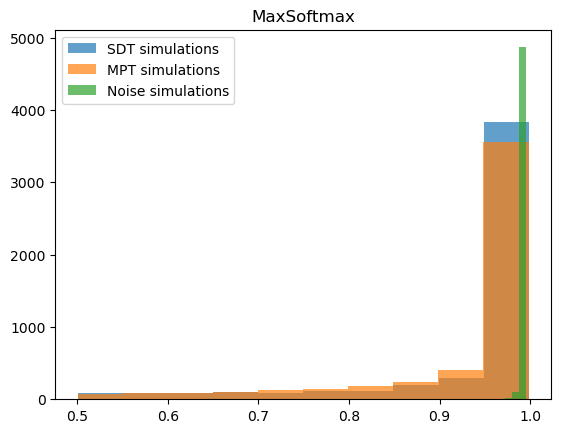

In [12]:
plt.hist(sdt_max_softmax, alpha=0.7, label='SDT simulations')
plt.hist(mpt_max_softmax, alpha=0.7, label='MPT simulations')
plt.hist(noise_max_softmax, alpha=0.7, label='Noise simulations')
plt.legend()
plt.title('MaxSoftmax')

## max_logits

In [13]:
#import tensorflow as tf
#tf.random.set_seed(2023) 
# fixes wildly differing results - but why are they so different when reloading the net in the first place??

sdt_max_logits = get_max_activation(sdt_data, probability_net, summary_net, 'max_logits')
mpt_max_logits = get_max_activation(mpt_data, probability_net, summary_net, 'max_logits')
noise_max_logits = get_max_activation(noise_data, probability_net, summary_net, 'max_logits')
print(np.mean(sdt_max_logits), np.mean(mpt_max_logits), np.mean(noise_max_logits))

1.6188658 2.0020926 2.163996


Text(0.5, 1.0, 'MaxLogit')

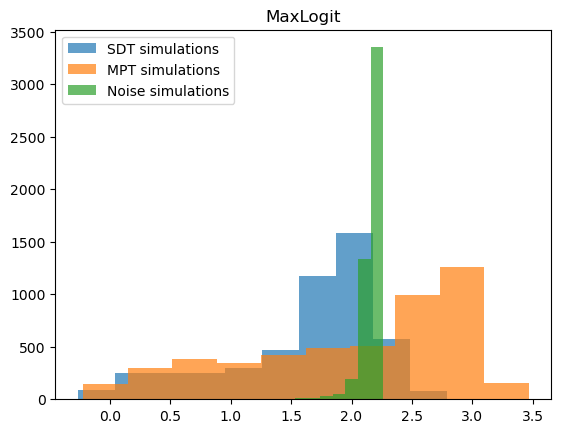

In [14]:
plt.hist(sdt_max_logits, alpha=0.7, label='SDT simulations')
plt.hist(mpt_max_logits, alpha=0.7, label='MPT simulations')
plt.hist(noise_max_logits, alpha=0.7, label='Noise simulations')
plt.legend()
plt.title('MaxLogit')

# Inspect predictions 

## SDT MPT data

ECE = 0.014


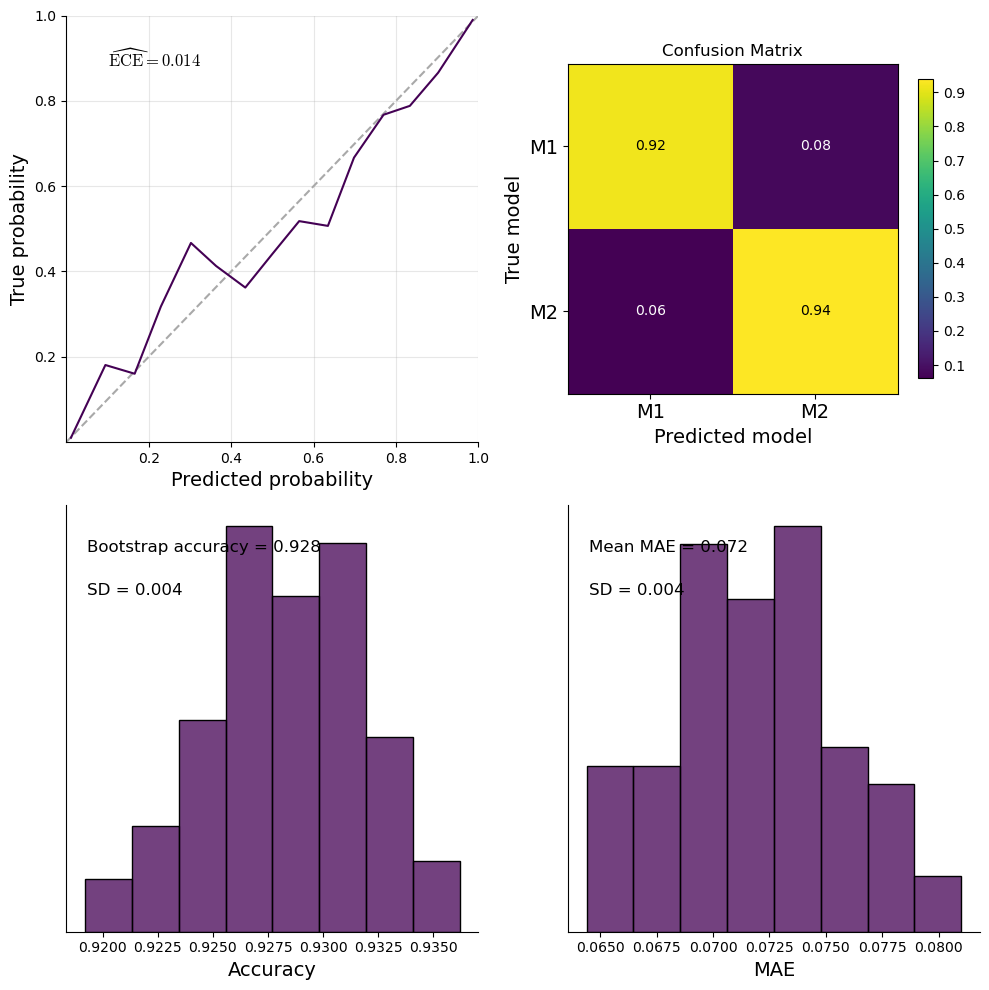

In [15]:
meta_model = bf.simulation.MultiGenerativeModel([sdt_simulator, mpt_simulator])
val_data = trainer.configurator(meta_model(5000))
perf_tester(probability_net, summary_net, val_data, n_cal_bins=15)

## Noisy data

ECE = 0.493


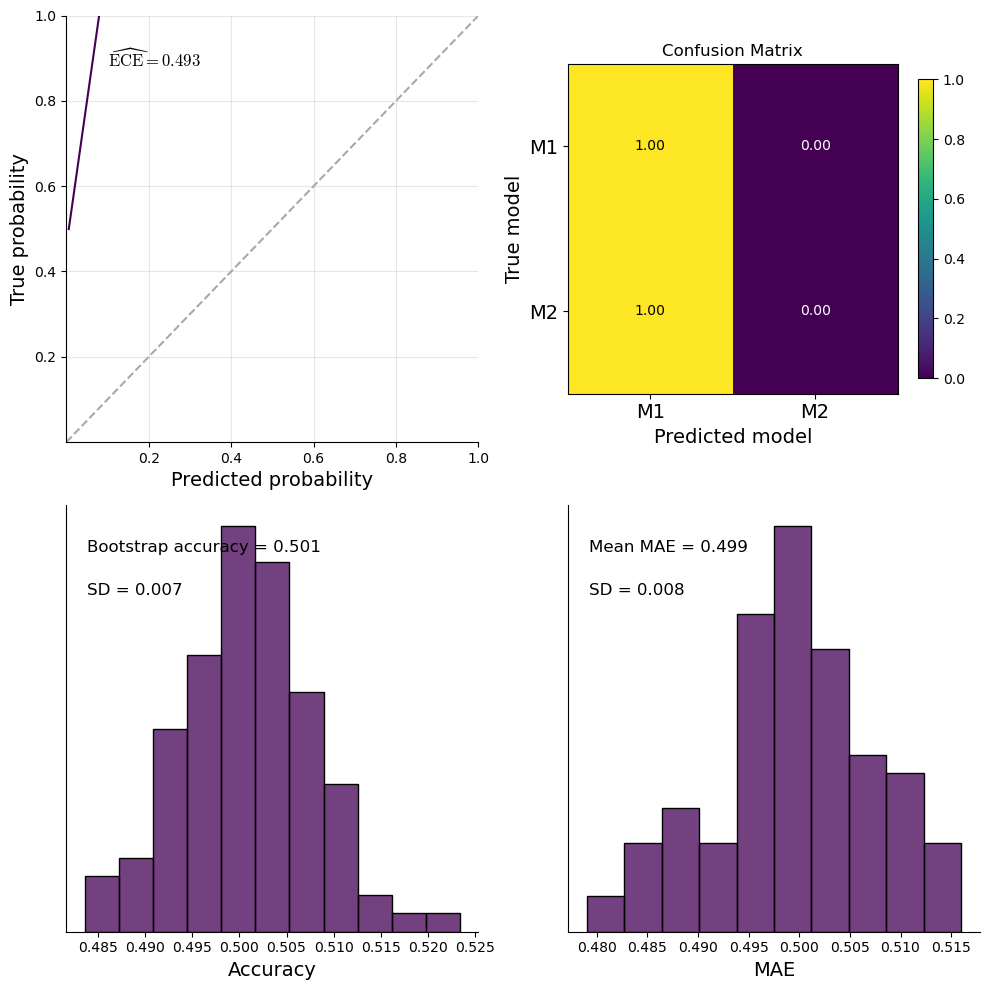

In [16]:
meta_noise = bf.simulation.MultiGenerativeModel([noise_simulator,noise_simulator])
val_data = trainer.configurator(meta_noise(5000))
perf_tester(probability_net, summary_net, val_data, n_cal_bins=15)

In [18]:
# check that both columns of simulated noise data are random
np.mean(noise_data, axis=(0,1,2))

array([0.4999912, 0.4998672])

In [19]:
# inspect predictions
noise_softmax = np.concatenate([probability_net.posterior_probs(summary_net(chunk)) for chunk in tf.split(noise_data, 20)])
np.mean(noise_softmax, axis=0)

array([0.994267 , 0.0057338], dtype=float32)

In [20]:
noise_softmax[:10,:]

array([[0.9948259 , 0.00517409],
       [0.99027467, 0.00972534],
       [0.99252   , 0.00748001],
       [0.9954717 , 0.00452831],
       [0.9954639 , 0.0045361 ],
       [0.9939169 , 0.00608313],
       [0.99427044, 0.00572959],
       [0.9945392 , 0.00546078],
       [0.9950547 , 0.00494522],
       [0.9954014 , 0.00459864]], dtype=float32)

In [22]:
# inspect logits
noise_logits=np.concatenate([probability_net.logits(summary_net(chunk)) for chunk in tf.split(noise_data, 20)])
np.mean(noise_logits, axis=0)

array([ 2.1639974, -3.046979 ], dtype=float32)

In [23]:
noise_logits[:10,:]

array([[ 2.2330387, -3.025865 ],
       [ 2.061687 , -2.5615604],
       [ 2.1381023, -2.749911 ],
       [ 2.151384 , -3.2414834],
       [ 2.1010807, -3.2900617],
       [ 2.191802 , -2.9043324],
       [ 2.211238 , -2.9451263],
       [ 2.221541 , -2.983147 ],
       [ 2.2357588, -3.0686173],
       [ 2.1912506, -3.1861353]], dtype=float32)

# Generate and save test data for comparison with bridge sampling

In [98]:
n_data_sets = 100
n_clusters = 25
n_obs = 50

noise_data_ood = noise_simulator(n_data_sets, RNG=np.random.default_rng(2023))['sim_data']

In [105]:
# save data sets
val_folder = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data', '02_bridge_sampling_comparison','non_nested_models')

np.save(os.path.join(val_folder, 'noise_data_ood'), noise_data_ood)

# Compare predictions

In [99]:
comparison_folder = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data', '02_bridge_sampling_comparison', 'non_nested_models')
bridge_file = '2023_06_15_BF_BS_ood'
bridge = pd.read_csv(os.path.join(comparison_folder, bridge_file), sep = " ").reset_index(drop=True)
NN = probability_net.posterior_probs(summary_net(noise_data_ood))

results_list = [bridge, NN]

In [100]:
NN_array = np.array(NN[:, 0])

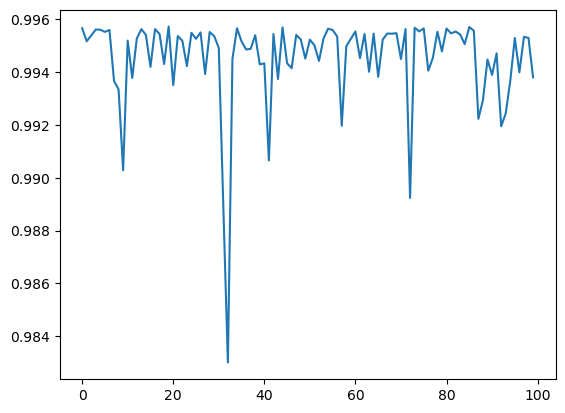

In [101]:
plt.plot(NN_array)

In [45]:
bridge_array = np.array(bridge.loc[:, "m0_prob"])

In [ ]:
plt.plot(bridge_array)

In [48]:
NN_array

array([0.9957112 , 0.99547464, 0.9953366 , 0.9945431 , 0.9956455 ,
       0.994436  , 0.99422365, 0.9956442 , 0.99558866, 0.9946802 ],
      dtype=float32)

In [49]:
bridge_array

array([0.99999538, 0.99997434, 0.9999993 , 0.99998499, 0.99999696,
       0.99999747, 0.99999993, 0.99994221, 0.99999976, 0.99999563])

In [ ]:
print(np.mean(NN_array))
print(np.std(NN_array))

In [ ]:
print(np.mean(bridge_array))
print(np.std(bridge_array))

In [104]:
print(np.mean(NN_array-bridge_array))
print(np.std(NN_array-bridge_array))

ValueError: operands could not be broadcast together with shapes (100,) (10,) 

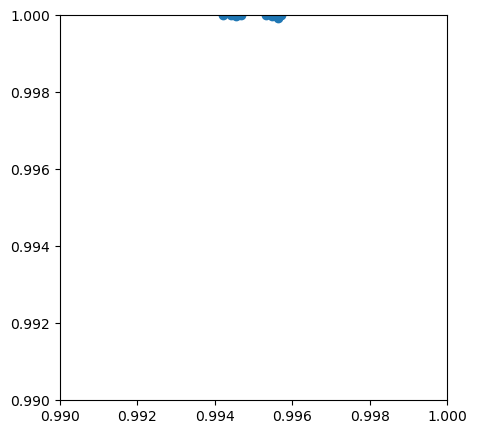

In [56]:
f, ax = plt.subplots(1, 1, figsize=(5,5))
ax.set_xlim([0.95, 1])
ax.set_ylim([0.95, 1])
ax.scatter(NN_array, bridge_array)